In [1]:
import codecs
from os import path
import pandas as pd
import pdb
import logging
import re
from gensim import parsing
import gensim
from gensim.parsing.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.metrics import classification_report
from baal.active import get_heuristic
from baal.active.active_loop import ActiveLearningLoop
from baal.active.dataset.nlp_datasets import active_huggingface_dataset, HuggingFaceDatasets
from baal.bayesian.dropout import patch_module
from baal.transformers_trainer_wrapper import BaalTransformersTrainer
from copy import deepcopy
from sklearn.metrics import accuracy_score

In [2]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("prajjwal1/bert-tiny") 
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="transformer_checkpoints",  # specify the directory where models weights will be saved a certain points during training (checkpoints)
    num_train_epochs=1,  # change this if it is taking too long on your computer
)  
def calculate(a):
    rotated = list(zip(*a[::-1]))
    median0 = []
    min0 = []
    max0 = []
    for i in range(len(rotated)):
        median0.append(np.median(rotated[i]))
        min0.append(np.min(rotated[i]))
        max0.append(np.max(rotated[i]))
    return median0,min0,max0

In [3]:
from datasets import load_dataset

cache_dir = "./data_cache"

train_dataset_abortion = load_dataset(
    "tweet_eval",
    name="stance_abortion",
    split="train",
    ignore_verifications=True,
    cache_dir=cache_dir,
)
print(f"Training dataset with {len(train_dataset_abortion)} instances loaded")

val_dataset_abortion = load_dataset(
    "tweet_eval",
    name="stance_abortion",
    split="validation",
    ignore_verifications=True,
    cache_dir=cache_dir,
)
print(f"Validation dataset with {len(val_dataset_abortion)} instances loaded")

test_dataset_abortion = load_dataset(
    "tweet_eval",
    name="stance_abortion",
    split="test",
    ignore_verifications=True,
    cache_dir=cache_dir,
)
print(f"Test dataset with {len(test_dataset_abortion)} instances loaded")

num_classes = np.unique(train_dataset_abortion['label']).size

Reusing dataset tweet_eval (./data_cache\tweet_eval\stance_abortion\1.1.0\12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


Training dataset with 587 instances loaded


Reusing dataset tweet_eval (./data_cache\tweet_eval\stance_abortion\1.1.0\12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


Validation dataset with 66 instances loaded


Reusing dataset tweet_eval (./data_cache\tweet_eval\stance_abortion\1.1.0\12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


Test dataset with 280 instances loaded


In [4]:
from transformers import AutoModelForSequenceClassification

model_original = AutoModelForSequenceClassification.from_pretrained("prajjwal1/bert-tiny", num_labels=num_classes)

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initia

In [7]:
active_mc_abortion1= []
mcrun = 0
al_epochs=30
np.random.seed()
number_abortion1 = [100]
while mcrun != 5:
#     n_labeled_examples = np.unique(train_dataset_abortion['text']).size
#     training_indices0 = np.random.randint(low=0, high=n_labeled_examples + 1, size=100)
#     print(training_indices0)
    active_set_abortion =active_huggingface_dataset(train_dataset_abortion,tokenizer,'label','text')
    valid_set_abortion = HuggingFaceDatasets(test_dataset_abortion,tokenizer,'label','text')
    # # lets randomly label 100 samples, therefore len(active_set) should be 100
    active_set_abortion.can_label = False
    active_set_abortion.label_randomly(100)
    from baal.active import get_heuristic
    heuristic = get_heuristic('entropy')
    model = patch_module(model_original)
    init_weights = deepcopy(model.state_dict())

    def compute_metrics(p):
        label = p.label_ids
        preds = np.argmax(p.predictions, axis=-1)
        return {
            'accuracy': accuracy_score(label, preds),
        }
    model = BaalTransformersTrainer(
            model=model,
            args=training_args,
            train_dataset=active_set_abortion,
            eval_dataset=valid_set_abortion,
            tokenizer=None,
            compute_metrics=compute_metrics)
    active_loop_abortion = ActiveLearningLoop(active_set_abortion,
                                 model.predict_on_dataset,
                                 heuristic, 20, iterations=1)
    model.train()
    unqueried_score=model.evaluate()['eval_accuracy']
    performance_history_abortion=[unqueried_score]
    for epoch in range(al_epochs):
        model.train()
        eval_metrics = model.evaluate()
        should_continue = active_loop_abortion.step()
        print(active_set_abortion.n_labelled)
        number_abortion1.append(active_set_abortion.n_labelled)
        model.load_state_dict(init_weights)
        model.lr_scheduler = None
        if not should_continue:
                break
        active_logs = {
            "epoch": epoch,
            "labeled_data": active_set_abortion.labelled_map,
            "Next Training set size": len(active_set_abortion),
        }
        logs = {**eval_metrics, **active_logs}
        performance_history_abortion.append(eval_metrics['eval_accuracy'])
    print(performance_history_abortion)
    active_mc_abortion1.append(performance_history_abortion)
    mcrun = mcrun + 1

D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 100
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


***** Running training *****
  Num examples = 100
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:39:08.795743Z [info     ] Start Predict                  dataset=487


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:02<00:00, 25.79it/s]


120


***** Running training *****
  Num examples = 120
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 15


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:39:15.478745Z [info     ] Start Predict                  dataset=467


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:02<00:00, 23.61it/s]


140


***** Running training *****
  Num examples = 140
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:39:22.947746Z [info     ] Start Predict                  dataset=447


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:02<00:00, 26.49it/s]


160


***** Running training *****
  Num examples = 160
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 20


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:39:30.528268Z [info     ] Start Predict                  dataset=427


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:02<00:00, 24.47it/s]


180


***** Running training *****
  Num examples = 180
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:39:37.765269Z [info     ] Start Predict                  dataset=407


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:02<00:00, 23.25it/s]


200


***** Running training *****
  Num examples = 200
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 25


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:39:45.896269Z [info     ] Start Predict                  dataset=387


100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:02<00:00, 20.09it/s]


220


***** Running training *****
  Num examples = 220
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:39:54.164791Z [info     ] Start Predict                  dataset=367


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:01<00:00, 25.88it/s]


240


***** Running training *****
  Num examples = 240
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 30


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:40:03.028361Z [info     ] Start Predict                  dataset=347


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 21.04it/s]


260


***** Running training *****
  Num examples = 260
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:40:11.671916Z [info     ] Start Predict                  dataset=327


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 24.55it/s]


280


***** Running training *****
  Num examples = 280
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 35


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:40:20.691918Z [info     ] Start Predict                  dataset=307


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 27.65it/s]


300


***** Running training *****
  Num examples = 300
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:40:29.610430Z [info     ] Start Predict                  dataset=287


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 24.93it/s]


320


***** Running training *****
  Num examples = 320
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 40


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:40:38.903428Z [info     ] Start Predict                  dataset=267


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 22.46it/s]


340


***** Running training *****
  Num examples = 340
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 43


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:40:48.565431Z [info     ] Start Predict                  dataset=247


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:01<00:00, 25.14it/s]


360


***** Running training *****
  Num examples = 360
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 45


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:40:57.982940Z [info     ] Start Predict                  dataset=227


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 21.15it/s]


380


***** Running training *****
  Num examples = 380
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 48


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:41:08.289942Z [info     ] Start Predict                  dataset=207


100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 24.71it/s]


400


***** Running training *****
  Num examples = 400
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 50


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:41:18.730686Z [info     ] Start Predict                  dataset=187


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 20.19it/s]


420


***** Running training *****
  Num examples = 420
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 53


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:41:28.748204Z [info     ] Start Predict                  dataset=167


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:01<00:00, 18.88it/s]


440


***** Running training *****
  Num examples = 440
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 55


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:41:40.752204Z [info     ] Start Predict                  dataset=147


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 24.74it/s]


460


***** Running training *****
  Num examples = 460
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 58


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:41:52.702329Z [info     ] Start Predict                  dataset=127


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 25.40it/s]


480


***** Running training *****
  Num examples = 480
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 60


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:42:04.589875Z [info     ] Start Predict                  dataset=107


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 28.57it/s]


500


***** Running training *****
  Num examples = 500
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 63


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:42:16.451375Z [info     ] Start Predict                  dataset=87


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 20.48it/s]


520


***** Running training *****
  Num examples = 520
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 65


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:42:28.881372Z [info     ] Start Predict                  dataset=67


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 25.71it/s]


540


***** Running training *****
  Num examples = 540
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 68


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:42:40.855542Z [info     ] Start Predict                  dataset=47


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 20.55it/s]


560


***** Running training *****
  Num examples = 560
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 70


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:42:53.959056Z [info     ] Start Predict                  dataset=27


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 24.69it/s]


580


***** Running training *****
  Num examples = 580
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 73


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:43:07.606055Z [info     ] Start Predict                  dataset=7


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.00it/s]


587


***** Running training *****
  Num examples = 587
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 74


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


587
[0.5821428571428572, 0.6142857142857143, 0.6428571428571429, 0.6607142857142857, 0.6607142857142857, 0.6607142857142857, 0.6357142857142857, 0.675, 0.6642857142857143, 0.675, 0.6642857142857143, 0.6714285714285714, 0.6678571428571428, 0.6714285714285714, 0.6607142857142857, 0.675, 0.675, 0.6714285714285714, 0.675, 0.675, 0.6678571428571428, 0.675, 0.675, 0.675, 0.675, 0.675]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 100
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


***** Running training *****
  Num examples = 100
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:43:28.094580Z [info     ] Start Predict                  dataset=487


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:02<00:00, 21.24it/s]


120


***** Running training *****
  Num examples = 120
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 15


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:43:35.731108Z [info     ] Start Predict                  dataset=467


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:02<00:00, 22.31it/s]


140


***** Running training *****
  Num examples = 140
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:43:43.532110Z [info     ] Start Predict                  dataset=447


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:02<00:00, 24.91it/s]


160


***** Running training *****
  Num examples = 160
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 20


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:43:50.430625Z [info     ] Start Predict                  dataset=427


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:02<00:00, 24.00it/s]


180


***** Running training *****
  Num examples = 180
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:43:58.623623Z [info     ] Start Predict                  dataset=407


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:02<00:00, 22.11it/s]


200


***** Running training *****
  Num examples = 200
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 25


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:44:06.776138Z [info     ] Start Predict                  dataset=387


100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 24.66it/s]


220


***** Running training *****
  Num examples = 220
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:44:15.394657Z [info     ] Start Predict                  dataset=367


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:02<00:00, 22.16it/s]


240


***** Running training *****
  Num examples = 240
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 30


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:44:23.314656Z [info     ] Start Predict                  dataset=347


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:01<00:00, 23.71it/s]


260


***** Running training *****
  Num examples = 260
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:44:32.434179Z [info     ] Start Predict                  dataset=327


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 21.99it/s]


280


***** Running training *****
  Num examples = 280
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 35


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:44:40.931699Z [info     ] Start Predict                  dataset=307


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 24.54it/s]


300


***** Running training *****
  Num examples = 300
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:44:50.438745Z [info     ] Start Predict                  dataset=287


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 24.36it/s]


320


***** Running training *****
  Num examples = 320
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 40


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:44:59.377783Z [info     ] Start Predict                  dataset=267


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 29.96it/s]


340


***** Running training *****
  Num examples = 340
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 43


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:45:08.799819Z [info     ] Start Predict                  dataset=247


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:01<00:00, 23.83it/s]


360


***** Running training *****
  Num examples = 360
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 45


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:45:17.984818Z [info     ] Start Predict                  dataset=227


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 21.06it/s]


380


***** Running training *****
  Num examples = 380
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 48


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:45:29.230334Z [info     ] Start Predict                  dataset=207


100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 23.09it/s]


400


***** Running training *****
  Num examples = 400
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 50


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:45:38.665334Z [info     ] Start Predict                  dataset=187


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 26.34it/s]


420


***** Running training *****
  Num examples = 420
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 53


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:45:49.616339Z [info     ] Start Predict                  dataset=167


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 25.58it/s]


440


***** Running training *****
  Num examples = 440
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 55


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:45:59.565337Z [info     ] Start Predict                  dataset=147


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 21.54it/s]


460


***** Running training *****
  Num examples = 460
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 58


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:46:11.673335Z [info     ] Start Predict                  dataset=127


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 21.07it/s]


480


***** Running training *****
  Num examples = 480
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 60


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:46:23.578374Z [info     ] Start Predict                  dataset=107


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 27.50it/s]


500


***** Running training *****
  Num examples = 500
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 63


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:46:34.989414Z [info     ] Start Predict                  dataset=87


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 22.22it/s]


520


***** Running training *****
  Num examples = 520
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 65


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:46:47.204415Z [info     ] Start Predict                  dataset=67


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 24.73it/s]


540


***** Running training *****
  Num examples = 540
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 68


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:46:58.539414Z [info     ] Start Predict                  dataset=47


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 27.78it/s]


560


***** Running training *****
  Num examples = 560
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 70


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:47:11.001414Z [info     ] Start Predict                  dataset=27


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 31.25it/s]


580


***** Running training *****
  Num examples = 580
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 73


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:47:23.771413Z [info     ] Start Predict                  dataset=7


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.73it/s]


587


***** Running training *****
  Num examples = 587
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 74


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


587
[0.6392857142857142, 0.6535714285714286, 0.6178571428571429, 0.6535714285714286, 0.6571428571428571, 0.65, 0.6571428571428571, 0.6785714285714286, 0.6607142857142857, 0.675, 0.6714285714285714, 0.675, 0.6714285714285714, 0.675, 0.675, 0.675, 0.675, 0.6714285714285714, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 100
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


***** Running training *****
  Num examples = 100
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:47:44.519651Z [info     ] Start Predict                  dataset=487


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:02<00:00, 21.78it/s]


120


***** Running training *****
  Num examples = 120
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 15


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:47:51.752172Z [info     ] Start Predict                  dataset=467


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:02<00:00, 21.75it/s]


140


***** Running training *****
  Num examples = 140
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:47:58.983169Z [info     ] Start Predict                  dataset=447


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:02<00:00, 21.63it/s]


160


***** Running training *****
  Num examples = 160
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 20


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:48:07.194688Z [info     ] Start Predict                  dataset=427


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:02<00:00, 21.91it/s]


180


***** Running training *****
  Num examples = 180
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:48:15.828587Z [info     ] Start Predict                  dataset=407


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:01<00:00, 28.55it/s]


200


***** Running training *****
  Num examples = 200
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 25


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:48:23.085105Z [info     ] Start Predict                  dataset=387


100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 24.64it/s]


220


***** Running training *****
  Num examples = 220
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:48:31.850106Z [info     ] Start Predict                  dataset=367


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:01<00:00, 26.51it/s]


240


***** Running training *****
  Num examples = 240
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 30


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:48:39.244105Z [info     ] Start Predict                  dataset=347


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 21.38it/s]


260


***** Running training *****
  Num examples = 260
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:48:48.479666Z [info     ] Start Predict                  dataset=327


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 27.38it/s]


280


***** Running training *****
  Num examples = 280
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 35


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:48:57.267734Z [info     ] Start Predict                  dataset=307


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 22.43it/s]


300


***** Running training *****
  Num examples = 300
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:49:06.063254Z [info     ] Start Predict                  dataset=287


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 23.40it/s]


320


***** Running training *****
  Num examples = 320
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 40


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:49:16.457308Z [info     ] Start Predict                  dataset=267


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 19.66it/s]


340


***** Running training *****
  Num examples = 340
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 43


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:49:26.419304Z [info     ] Start Predict                  dataset=247


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:01<00:00, 26.82it/s]


360


***** Running training *****
  Num examples = 360
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 45


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:49:36.432308Z [info     ] Start Predict                  dataset=227


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 26.10it/s]


380


***** Running training *****
  Num examples = 380
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 48


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:49:46.151873Z [info     ] Start Predict                  dataset=207


100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 26.83it/s]


400


***** Running training *****
  Num examples = 400
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 50


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:49:56.700874Z [info     ] Start Predict                  dataset=187


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 23.21it/s]


420


***** Running training *****
  Num examples = 420
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 53


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:50:06.756872Z [info     ] Start Predict                  dataset=167


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 28.77it/s]


440


***** Running training *****
  Num examples = 440
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 55


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:50:17.205870Z [info     ] Start Predict                  dataset=147


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 31.00it/s]


460


***** Running training *****
  Num examples = 460
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 58


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:50:28.115441Z [info     ] Start Predict                  dataset=127


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 22.38it/s]


480


***** Running training *****
  Num examples = 480
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 60


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:50:39.047439Z [info     ] Start Predict                  dataset=107


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 22.47it/s]


500


***** Running training *****
  Num examples = 500
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 63


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:50:50.495440Z [info     ] Start Predict                  dataset=87


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 26.76it/s]


520


***** Running training *****
  Num examples = 520
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 65


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:51:03.836966Z [info     ] Start Predict                  dataset=67


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 21.38it/s]


540


***** Running training *****
  Num examples = 540
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 68


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:51:18.123480Z [info     ] Start Predict                  dataset=47


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 21.20it/s]


560


***** Running training *****
  Num examples = 560
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 70


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:51:30.701484Z [info     ] Start Predict                  dataset=27


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.60it/s]


580


***** Running training *****
  Num examples = 580
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 73


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:51:43.030010Z [info     ] Start Predict                  dataset=7


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.74it/s]


587


***** Running training *****
  Num examples = 587
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 74


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


587
[0.6392857142857142, 0.6535714285714286, 0.6178571428571429, 0.6535714285714286, 0.6571428571428571, 0.65, 0.6571428571428571, 0.6785714285714286, 0.6607142857142857, 0.675, 0.6714285714285714, 0.675, 0.6714285714285714, 0.675, 0.675, 0.675, 0.675, 0.6714285714285714, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 100
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


***** Running training *****
  Num examples = 100
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:52:03.178136Z [info     ] Start Predict                  dataset=487


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:02<00:00, 20.76it/s]


120


***** Running training *****
  Num examples = 120
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 15


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:52:10.792177Z [info     ] Start Predict                  dataset=467


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:02<00:00, 21.97it/s]


140


***** Running training *****
  Num examples = 140
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:52:17.980704Z [info     ] Start Predict                  dataset=447


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:02<00:00, 25.70it/s]


160


***** Running training *****
  Num examples = 160
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 20


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:52:25.275695Z [info     ] Start Predict                  dataset=427


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:01<00:00, 28.45it/s]


180


***** Running training *****
  Num examples = 180
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:52:33.534212Z [info     ] Start Predict                  dataset=407


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:02<00:00, 19.25it/s]


200


***** Running training *****
  Num examples = 200
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 25


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:52:42.452244Z [info     ] Start Predict                  dataset=387


100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:02<00:00, 24.44it/s]


220


***** Running training *****
  Num examples = 220
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:52:51.044244Z [info     ] Start Predict                  dataset=367


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:02<00:00, 21.33it/s]


240


***** Running training *****
  Num examples = 240
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 30


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:52:59.446244Z [info     ] Start Predict                  dataset=347


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:01<00:00, 22.51it/s]


260


***** Running training *****
  Num examples = 260
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:53:09.060295Z [info     ] Start Predict                  dataset=327


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 26.05it/s]


280


***** Running training *****
  Num examples = 280
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 35


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:53:17.104078Z [info     ] Start Predict                  dataset=307


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 21.23it/s]


300


***** Running training *****
  Num examples = 300
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:53:27.160595Z [info     ] Start Predict                  dataset=287


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 23.11it/s]


320


***** Running training *****
  Num examples = 320
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 40


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:53:35.791116Z [info     ] Start Predict                  dataset=267


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 24.98it/s]


340


***** Running training *****
  Num examples = 340
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 43


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:53:45.421643Z [info     ] Start Predict                  dataset=247


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:01<00:00, 26.70it/s]


360


***** Running training *****
  Num examples = 360
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 45


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:53:55.405160Z [info     ] Start Predict                  dataset=227


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 22.93it/s]


380


***** Running training *****
  Num examples = 380
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 48


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:54:04.928193Z [info     ] Start Predict                  dataset=207


100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 23.77it/s]


400


***** Running training *****
  Num examples = 400
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 50


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:54:16.400207Z [info     ] Start Predict                  dataset=187


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 28.74it/s]


420


***** Running training *****
  Num examples = 420
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 53


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:54:26.734254Z [info     ] Start Predict                  dataset=167


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 30.04it/s]


440


***** Running training *****
  Num examples = 440
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 55


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:54:37.752601Z [info     ] Start Predict                  dataset=147


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 22.62it/s]


460


***** Running training *****
  Num examples = 460
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 58


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:54:48.241033Z [info     ] Start Predict                  dataset=127


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 22.54it/s]


480


***** Running training *****
  Num examples = 480
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 60


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:55:00.144036Z [info     ] Start Predict                  dataset=107


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 23.85it/s]


500


***** Running training *****
  Num examples = 500
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 63


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:55:11.436177Z [info     ] Start Predict                  dataset=87


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 24.50it/s]


520


***** Running training *****
  Num examples = 520
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 65


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:55:23.787180Z [info     ] Start Predict                  dataset=67


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 25.64it/s]


540


***** Running training *****
  Num examples = 540
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 68


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:55:35.279180Z [info     ] Start Predict                  dataset=47


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 22.39it/s]


560


***** Running training *****
  Num examples = 560
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 70


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:55:47.295179Z [info     ] Start Predict                  dataset=27


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 28.57it/s]


580


***** Running training *****
  Num examples = 580
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 73


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:55:59.400179Z [info     ] Start Predict                  dataset=7


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.03it/s]


587


***** Running training *****
  Num examples = 587
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 74


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


587
[0.6392857142857142, 0.6535714285714286, 0.6178571428571429, 0.6535714285714286, 0.6571428571428571, 0.65, 0.6571428571428571, 0.6785714285714286, 0.6607142857142857, 0.675, 0.6714285714285714, 0.675, 0.6714285714285714, 0.675, 0.675, 0.675, 0.675, 0.6714285714285714, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 100
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


***** Running training *****
  Num examples = 100
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:56:19.273696Z [info     ] Start Predict                  dataset=487


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:02<00:00, 23.34it/s]


120


***** Running training *****
  Num examples = 120
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 15


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:56:28.776596Z [info     ] Start Predict                  dataset=467


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:01<00:00, 29.53it/s]


140


***** Running training *****
  Num examples = 140
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:56:35.065597Z [info     ] Start Predict                  dataset=447


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:02<00:00, 21.05it/s]


160


***** Running training *****
  Num examples = 160
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 20


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:56:42.848114Z [info     ] Start Predict                  dataset=427


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:01<00:00, 27.29it/s]


180


***** Running training *****
  Num examples = 180
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:56:50.170145Z [info     ] Start Predict                  dataset=407


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:02<00:00, 22.05it/s]


200


***** Running training *****
  Num examples = 200
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 25


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:56:58.684708Z [info     ] Start Predict                  dataset=387


100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:02<00:00, 22.33it/s]


220


***** Running training *****
  Num examples = 220
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:57:06.893223Z [info     ] Start Predict                  dataset=367


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:01<00:00, 24.83it/s]


240


***** Running training *****
  Num examples = 240
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 30


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:57:15.603782Z [info     ] Start Predict                  dataset=347


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 21.00it/s]


260


***** Running training *****
  Num examples = 260
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:57:25.946922Z [info     ] Start Predict                  dataset=327


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 29.00it/s]


280


***** Running training *****
  Num examples = 280
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 35


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:57:34.123917Z [info     ] Start Predict                  dataset=307


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 22.65it/s]


300


***** Running training *****
  Num examples = 300
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:57:43.830918Z [info     ] Start Predict                  dataset=287


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 24.98it/s]


320


***** Running training *****
  Num examples = 320
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 40


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:57:52.231446Z [info     ] Start Predict                  dataset=267


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 22.70it/s]


340


***** Running training *****
  Num examples = 340
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 43


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:58:02.345446Z [info     ] Start Predict                  dataset=247


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:01<00:00, 24.12it/s]


360


***** Running training *****
  Num examples = 360
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 45


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:58:13.252500Z [info     ] Start Predict                  dataset=227


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 22.50it/s]


380


***** Running training *****
  Num examples = 380
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 48


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:58:23.219052Z [info     ] Start Predict                  dataset=207


100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 20.12it/s]


400


***** Running training *****
  Num examples = 400
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 50


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:58:34.007599Z [info     ] Start Predict                  dataset=187


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 26.73it/s]


420


***** Running training *****
  Num examples = 420
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 53


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:58:44.326640Z [info     ] Start Predict                  dataset=167


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 25.77it/s]


440


***** Running training *****
  Num examples = 440
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 55


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:58:55.314678Z [info     ] Start Predict                  dataset=147


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 22.89it/s]


460


***** Running training *****
  Num examples = 460
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 58


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:59:05.747714Z [info     ] Start Predict                  dataset=127


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 24.88it/s]


480


***** Running training *****
  Num examples = 480
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 60


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:59:16.893280Z [info     ] Start Predict                  dataset=107


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 22.26it/s]


500


***** Running training *****
  Num examples = 500
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 63


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:59:27.927805Z [info     ] Start Predict                  dataset=87


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 25.23it/s]


520


***** Running training *****
  Num examples = 520
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 65


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:59:39.527370Z [info     ] Start Predict                  dataset=67


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 23.32it/s]


540


***** Running training *****
  Num examples = 540
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 68


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T19:59:51.590404Z [info     ] Start Predict                  dataset=47


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 26.09it/s]


560


***** Running training *****
  Num examples = 560
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 70


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T20:00:03.790451Z [info     ] Start Predict                  dataset=27


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 26.32it/s]


580


***** Running training *****
  Num examples = 580
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 73


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[14728-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-30T20:00:17.725450Z [info     ] Start Predict                  dataset=7


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.28it/s]


587


***** Running training *****
  Num examples = 587
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 74


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


587
[0.6392857142857142, 0.6535714285714286, 0.6178571428571429, 0.6535714285714286, 0.6571428571428571, 0.65, 0.6571428571428571, 0.6785714285714286, 0.6607142857142857, 0.675, 0.6714285714285714, 0.675, 0.6714285714285714, 0.675, 0.675, 0.675, 0.675, 0.6714285714285714, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675]


In [8]:
median_abortion1, min_abortion1,max_abortion1 = calculate(active_mc_abortion1)

In [9]:
len(median_abortion1)

26

In [11]:
number_abortion1=number_abortion1[0:26]

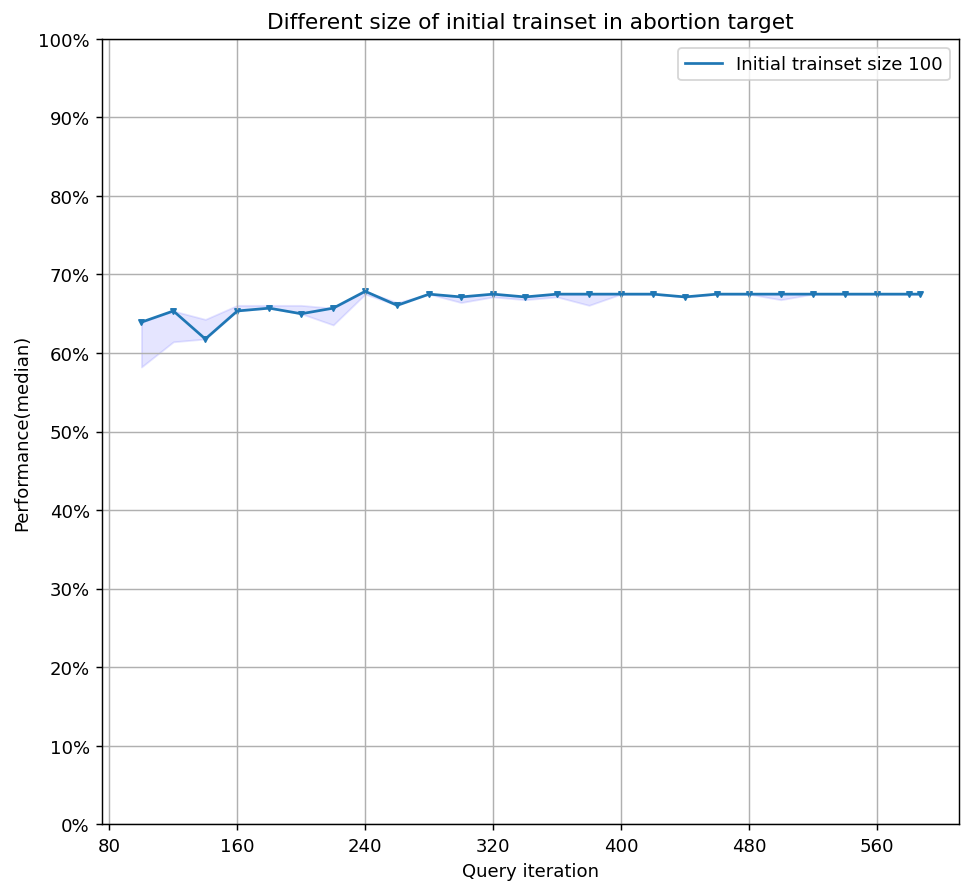

In [13]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8.5, 8), dpi=130)
ax.plot(number_abortion1,median_abortion1,label="Initial trainset size 100")
ax.fill_between(number_abortion1,min_abortion1,max_abortion1,color='blue', alpha=0.1)

ax.scatter(number_abortion1, median_abortion1, s=8,marker = "v")

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=8, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)
ax.legend()
ax.set_title('Different size of initial trainset in abortion target')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Performance(median)')

plt.show()

In [14]:
fig.savefig('abortion_100.jpg')